# Étape 1 : Chargement et préparation du dataset Allociné


In [1]:
!pip install transformers datasets torch accelerate evaluate scikit-learn
!pip install pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation du device: {device}")

Utilisation du device: cuda


In [4]:

# ============================================================================
# CHARGEMENT DU DATASET ALLOCINÉ
# ============================================================================

print("\n" + "="*60)
print(" CHARGEMENT DU DATASET ALLOCINÉ")
print("="*60)

print(" Téléchargement du dataset Allociné depuis Hugging Face...")


# Charger le dataset complet
dataset = load_dataset("allocine")

print(f" Dataset Allociné chargé avec succès !")
print(f" Structure du dataset :")
print(f"   • Train: {len(dataset['train']):,} avis")
print(f"   • Validation: {len(dataset['validation']):,} avis")
print(f"   • Test: {len(dataset['test']):,} avis")
print(f"   • Total: {len(dataset['train']) + len(dataset['validation']) + len(dataset['test']):,} avis")


 CHARGEMENT DU DATASET ALLOCINÉ
 Téléchargement du dataset Allociné depuis Hugging Face...


README.md: 0.00B [00:00, ?B/s]

allocine/train-00000-of-00001.parquet:   0%|          | 0.00/60.0M [00:00<?, ?B/s]

allocine/validation-00000-of-00001.parqu(…):   0%|          | 0.00/7.58M [00:00<?, ?B/s]

allocine/test-00000-of-00001.parquet:   0%|          | 0.00/7.58M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

 Dataset Allociné chargé avec succès !
 Structure du dataset :
   • Train: 160,000 avis
   • Validation: 20,000 avis
   • Test: 20,000 avis
   • Total: 200,000 avis


In [5]:

# ============================================================================
# EXPLORATION DU DATASET
# ============================================================================

print("\n" + "="*60)
print("EXPLORATION DU DATASET ALLOCINÉ")
print("="*60)

# Convertir en DataFrames pour l'exploration
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

print(" Aperçu des données :")
print(train_df.head())

print(f"\n Colonnes disponibles : {list(train_df.columns)}")

# Mapping des labels (Allociné utilise 0=négatif, 1=positif)
label_mapping = {0: 'Négatif', 1: 'Positif'}
print(f"\n Mapping des labels : {label_mapping}")

# Distribution des labels
print(f"\n Distribution des sentiments dans le train :")
train_counts = train_df['label'].value_counts().sort_index()
for label, count in train_counts.items():
    percentage = count / len(train_df) * 100
    print(f"   {label_mapping[label]}: {count:,} avis ({percentage:.1f}%)")

print(f"\n Distribution des sentiments dans le test :")
test_counts = test_df['label'].value_counts().sort_index()
for label, count in test_counts.items():
    percentage = count / len(test_df) * 100
    print(f"   {label_mapping[label]}: {count:,} avis ({percentage:.1f}%)")


EXPLORATION DU DATASET ALLOCINÉ
 Aperçu des données :
                                              review  label
0  Si vous cherchez du cinéma abrutissant à tous ...      0
1  Trash, re-trash et re-re-trash...! Une horreur...      0
2  Et si, dans les 5 premières minutes du film, l...      0
3  Mon dieu ! Quelle métaphore filée ! Je suis ab...      0
4  Premier film de la saga Kozure Okami, "Le Sabr...      1

 Colonnes disponibles : ['review', 'label']

 Mapping des labels : {0: 'Négatif', 1: 'Positif'}

 Distribution des sentiments dans le train :
   Négatif: 79,413 avis (49.6%)
   Positif: 80,587 avis (50.4%)

 Distribution des sentiments dans le test :
   Négatif: 10,408 avis (52.0%)
   Positif: 9,592 avis (48.0%)


In [6]:

# ============================================================================
# ANALYSE DE LA LONGUEUR DES TEXTES
# ============================================================================

print(f"\n Analyse de la longueur des avis :")

# Calculer les statistiques de longueur
train_df['text_length'] = train_df['review'].str.len()
train_df['word_count'] = train_df['review'].str.split().str.len()

print(f"   Longueur moyenne: {train_df['text_length'].mean():.0f} caractères")
print(f"   Longueur médiane: {train_df['text_length'].median():.0f} caractères")
print(f"   Nombre de mots moyen: {train_df['word_count'].mean():.1f} mots")
print(f"   Avis le plus court: {train_df['text_length'].min()} caractères")
print(f"   Avis le plus long: {train_df['text_length'].max()} caractères")


 Analyse de la longueur des avis :
   Longueur moyenne: 542 caractères
   Longueur médiane: 389 caractères
   Nombre de mots moyen: 91.3 mots
   Avis le plus court: 3 caractères
   Avis le plus long: 2000 caractères



 Création des visualisations...


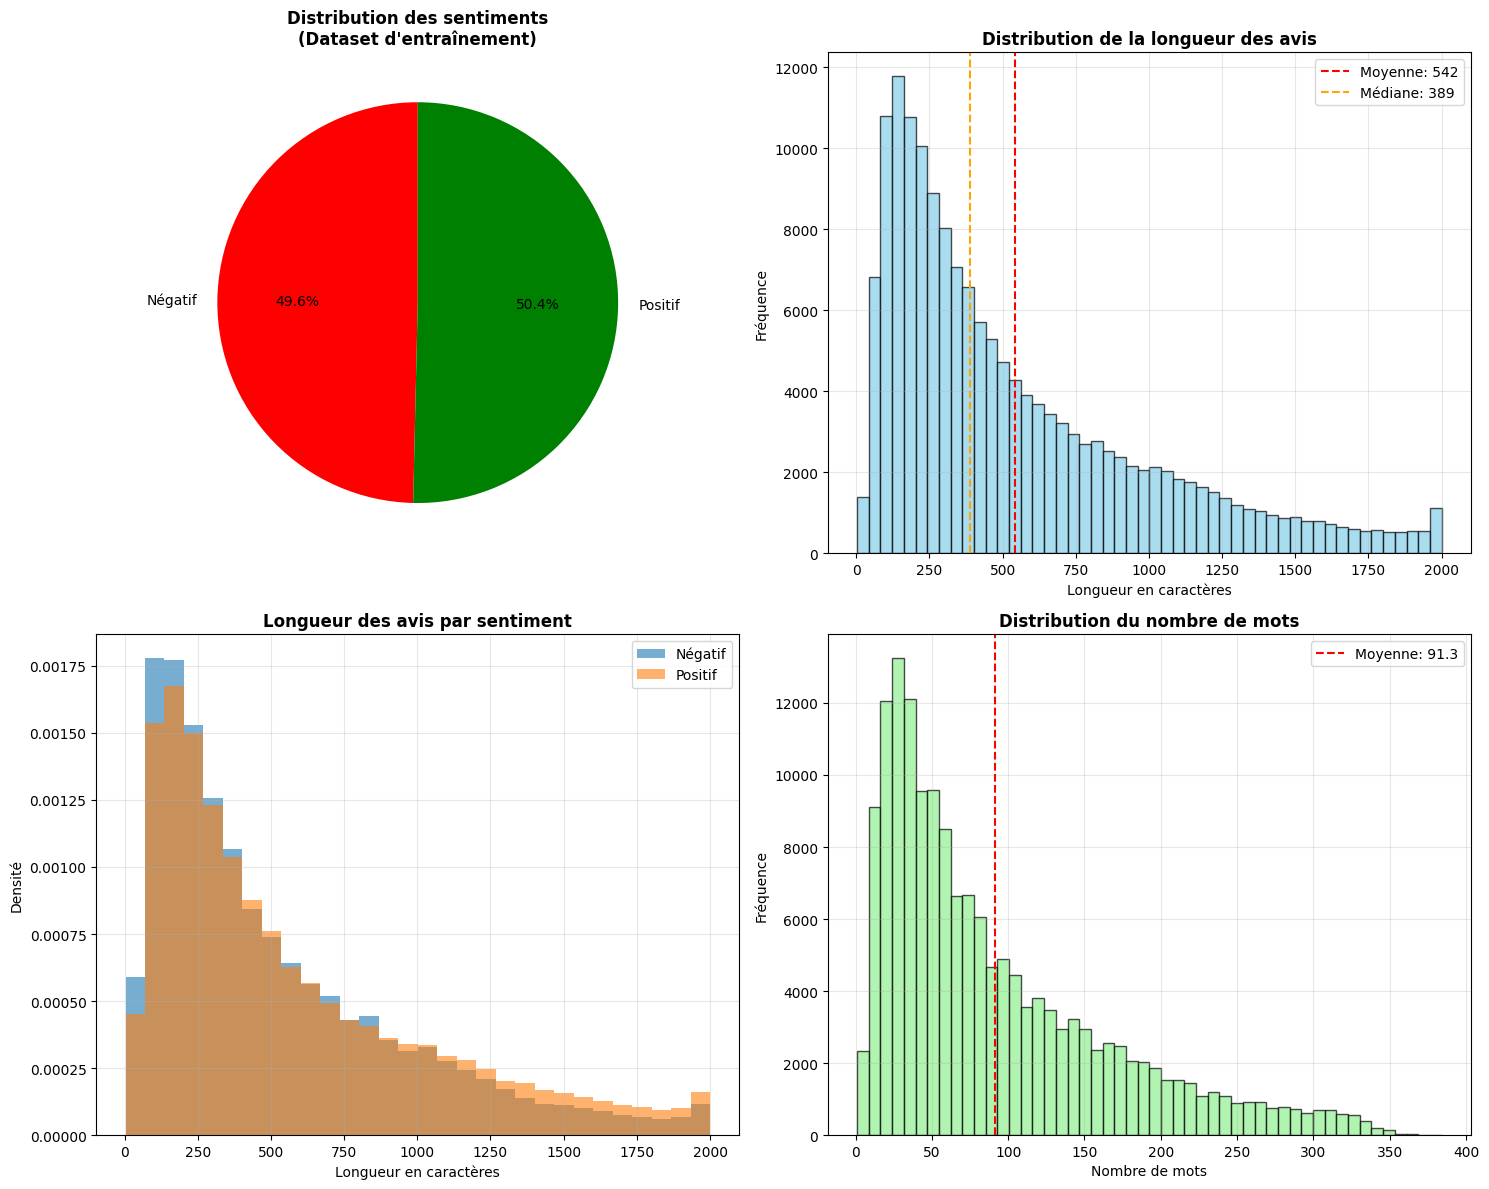

In [7]:

# ============================================================================
# VISUALISATIONS
# ============================================================================

print(f"\n Création des visualisations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution des sentiments
ax1 = axes[0, 0]
labels = [label_mapping[i] for i in train_counts.index]
colors = ['red', 'green']
wedges, texts, autotexts = ax1.pie(train_counts.values, labels=labels, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax1.set_title('Distribution des sentiments\n(Dataset d\'entraînement)', fontsize=12, fontweight='bold')

# 2. Distribution de la longueur des textes
ax2 = axes[0, 1]
ax2.hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(train_df['text_length'].mean(), color='red', linestyle='--',
           label=f'Moyenne: {train_df["text_length"].mean():.0f}')
ax2.axvline(train_df['text_length'].median(), color='orange', linestyle='--',
           label=f'Médiane: {train_df["text_length"].median():.0f}')
ax2.set_xlabel('Longueur en caractères')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution de la longueur des avis', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Longueur par sentiment
ax3 = axes[1, 0]
for label in [0, 1]:
    subset = train_df[train_df['label'] == label]['text_length']
    ax3.hist(subset, bins=30, alpha=0.6, label=label_mapping[label], density=True)
ax3.set_xlabel('Longueur en caractères')
ax3.set_ylabel('Densité')
ax3.set_title('Longueur des avis par sentiment', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Nombre de mots
ax4 = axes[1, 1]
ax4.hist(train_df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
ax4.axvline(train_df['word_count'].mean(), color='red', linestyle='--',
           label=f'Moyenne: {train_df["word_count"].mean():.1f}')
ax4.set_xlabel('Nombre de mots')
ax4.set_ylabel('Fréquence')
ax4.set_title('Distribution du nombre de mots', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================================
# EXEMPLES D'AVIS PAR SENTIMENT
# ============================================================================

print("\n" + "="*60)
print(" EXEMPLES D'AVIS PAR SENTIMENT")
print("="*60)

for label_id, sentiment_name in label_mapping.items():
    print(f"\n{sentiment_name.upper()} :")
    examples = train_df[train_df['label'] == label_id]['review'].head(3).tolist()
    for i, example in enumerate(examples, 1):
        # Tronquer si trop long pour l'affichage
        display_text = example[:200] + "..." if len(example) > 200 else example
        print(f"  {i}. \"{display_text}\"")



 EXEMPLES D'AVIS PAR SENTIMENT

NÉGATIF :
  1. "Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via..."
  2. "Trash, re-trash et re-re-trash...! Une horreur sans nom. Imaginez-vous les 20 premières minutes de Orange Mécanique dilatées sur plus de 70 minutes de bande VHS pourrave et revisitées par Korine à la ..."
  3. "Et si, dans les 5 premières minutes du film, la pathétique maquette de train fendant la neige en gros plan laissait bien augurer du reste ? Si cet artifice trop visible illustrait toute la lourdeur de..."

POSITIF :
  1. "Premier film de la saga Kozure Okami, "Le Sabre de la vengeance" est un très bon film qui mêle drame et action, et qui, en 40 ans, n'a pas pris une ride."
  2. "Tout commence comme une comédie légère avant un drame soudain qui fait basculer le film dans un...suspense incroyable mâtiné d'une étude psycholog

In [9]:
# ============================================================================
# CRÉATION D'UN SOUS-ÉCHANTILLON POUR L'ENTRAÎNEMENT
# ============================================================================

print("\n" + "="*60)
print(" CRÉATION D'UN SOUS-ÉCHANTILLON MANAGEABLE")
print("="*60)

# Pour l'entraînement sur Colab, on va prendre un sous-échantillon
# Car 160k exemples c'est trop pour un entraînement rapide
TRAIN_SAMPLE_SIZE = 2000  # 1000 par classe
TEST_SAMPLE_SIZE = 400    # 200 par classe

print(f" Création d'un échantillon d'entraînement de {TRAIN_SAMPLE_SIZE} avis...")
print(f" Raison : Entraînement plus rapide sur Colab tout en gardant des résultats significatifs")

# Échantillonner de manière stratifiée
def stratified_sample(df, n_samples, label_col='label'):
    """Échantillonne de manière stratifiée"""
    sampled_dfs = []
    for label in df[label_col].unique():
        label_df = df[df[label_col] == label]
        n_per_class = n_samples // len(df[label_col].unique())
        sampled_df = label_df.sample(n=min(n_per_class, len(label_df)), random_state=42)
        sampled_dfs.append(sampled_df)
    return pd.concat(sampled_dfs, ignore_index=True).sample(frac=1, random_state=42)

# Créer les échantillons
train_sample = stratified_sample(train_df, TRAIN_SAMPLE_SIZE)
test_sample = stratified_sample(test_df, TEST_SAMPLE_SIZE)

print(f" Échantillons créés :")
print(f"   Train: {len(train_sample)} avis")
print(f"   Test: {len(test_sample)} avis")

# Vérifier la distribution
print(f"\n Distribution dans l'échantillon d'entraînement :")
sample_counts = train_sample['label'].value_counts().sort_index()
for label, count in sample_counts.items():
    percentage = count / len(train_sample) * 100
    print(f"   {label_mapping[label]}: {count} avis ({percentage:.1f}%)")


 CRÉATION D'UN SOUS-ÉCHANTILLON MANAGEABLE
 Création d'un échantillon d'entraînement de 2000 avis...
 Raison : Entraînement plus rapide sur Colab tout en gardant des résultats significatifs
 Échantillons créés :
   Train: 2000 avis
   Test: 400 avis

 Distribution dans l'échantillon d'entraînement :
   Négatif: 1000 avis (50.0%)
   Positif: 1000 avis (50.0%)


In [10]:
# ============================================================================
# SAUVEGARDE DES DONNÉES
# ============================================================================

print("\n" + "="*60)
print(" SAUVEGARDE DES DONNÉES")
print("="*60)

train_sample_final = train_sample[['review', 'label']].copy()
train_sample_final = train_sample_final.rename(columns={'review': 'text'})

test_sample_final = test_sample[['review', 'label']].copy()
test_sample_final = test_sample_final.rename(columns={'review': 'text'})

# Sauvegarder
train_sample_final.to_csv('train_data_allocine.csv', index=False)
test_sample_final.to_csv('test_data_allocine.csv', index=False)

print(f" Données sauvegardées :")
print(f"   • train_data_allocine.csv: {len(train_sample_final)} avis")
print(f"   • test_data_allocine.csv: {len(test_sample_final)} avis")

# Sauvegarder aussi un échantillon du dataset complet pour référence
full_test_sample = test_df[['review', 'label']].sample(n=1000, random_state=42)
full_test_sample = full_test_sample.rename(columns={'review': 'text'})
full_test_sample.to_csv('test_data_allocine_full.csv', index=False)

print(f"   • test_data_allocine_full.csv: 1000 avis (pour évaluation complète)")


 SAUVEGARDE DES DONNÉES
 Données sauvegardées :
   • train_data_allocine.csv: 2000 avis
   • test_data_allocine.csv: 400 avis
   • test_data_allocine_full.csv: 1000 avis (pour évaluation complète)
